## Capstone Project - The Battle of Neighborhoods

### 1. Setting up the environment

#### A. Downloads & Imports

In [1]:
import itertools

# Data analysis.
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Web scraping
import requests
import json
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pandas.io.json import json_normalize

# Machine learning.
from sklearn.cluster import KMeans 
from sklearn import linear_model
from sklearn.datasets.samples_generator import make_blobs
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Geolocation.
!conda install -c conda-forge geocoder --yes 
import geocoder
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
!conda install -c conda-forge folium=0.5.0 --yes
import folium

# Visualization.
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import matplotlib.cm as mpcm
import matplotlib.colors as colors
import seaborn as sns

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    orderedset-2.0             |           py36_0         231 KB  conda-forge
    geocoder-1.38.1            |             py_0          52 KB  conda-forge
    ratelim-0.1.6              |           py36_0           5 KB  conda-forge
    conda-4.5.11               |        py36_1000         651 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTAL

#### B. FourSquare API

In [2]:
CLIENT_ID = 'FWABH3UY2JW0GJM0XA4S1YCIBRWG4XY44GB4FG2VOVC1T1GY'
CLIENT_SECRET = 'NGWXIULWCHACLDQNI5GFPG43JWZ54FA4TSSR2JJBJGNBANFH'
VERSION = '20181020'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: FWABH3UY2JW0GJM0XA4S1YCIBRWG4XY44GB4FG2VOVC1T1GY
CLIENT_SECRET:NGWXIULWCHACLDQNI5GFPG43JWZ54FA4TSSR2JJBJGNBANFH


### 2. Scraping wikipedia pages for data

#### A. Parsing the wikipedia pages

In [3]:
url_borough = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page_borough = urlopen(url_borough).read().decode('utf-8')
soup_borough = BeautifulSoup(page_borough, 'html.parser')

borough_table = soup_borough.body.table.tbody  # Getting the table in the page.

In [4]:
url_demographics = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
page_demographics = urlopen(url_demographics).read().decode('utf-8')
soup_demographics = BeautifulSoup(page_demographics,'html.parser')

demographics_table = soup_demographics.find_all('table')[1]
demographics_rows = demographics_table.find_all('tr')

demographics_data = []  # Demographics table is stored in here.

for row in demographics_rows:
    td = row.find_all('td')
    processed_row = [row.text.strip() for row in td if row.text.strip()]
    if processed_row:
        demographics_data.append(processed_row)  

#### B. Helper functions for retrieving data from cells inside the table

In [5]:
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row

def get_row(table):    
    data = []  
    
    for tr in table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

borough_data = get_row(borough_table)  # Borough table is stored here.

### 3. Building DataFrame from the tables

#### A. Borough df

In [6]:
columns_borough = ['Postcode', 'Borough', 'Neighbourhood']
df_borough = pd.DataFrame(borough_data, columns=columns_borough)

df_borough = df_borough[df_borough.Borough != 'Not assigned']  # Getting rid of rows with 'Not assigned' Borough
df_borough.loc[df_borough['Neighbourhood'] == 'Not assigned', ['Neighbourhood']] = 'Queen\'s Park'  # Assigning the Borough to the 'Not assigned' Neighbourhood

df_borough.reset_index(inplace=True)
df_borough.drop('index', axis=1, inplace=True)

df_borough.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


#### B. Demographics df

In [7]:
columns_demographics = ["Neighbourhood", 
                        "FM", 
                        "Census", 
                        "Population", 
                        "Land Area", 
                        "Density", 
                        "Population Change", 
                        "Average Income", 
                        "Transit Commuting", 
                        "Renters", 
                        "2nd Language", 
                        "2nd Language %"]

df_demographics = pd.DataFrame(demographics_data, columns=columns_demographics)
df_demographics.drop(df_demographics.index[0], inplace=True)
df_demographics.reset_index(inplace=True)
df_demographics.drop(['index', 'FM', 'Census', 'Renters'], axis=1, inplace=True)
df_demographics['Borough'] = ''
df_demographics['Postcode'] = ''

df_demographics.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode
0,Agincourt,"44,577",12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,,
1,Alderwood,"11,656",4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,,
2,Alexandra Park,"4,355",0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
3,Allenby,"2,513",0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
4,Amesbury,"17,318",3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,


#### C. Borough and Demographics merged df

In [8]:
# This loop merges the borough and demographics data.
for i in df_demographics.index:
    for j in df_borough.index:
        if df_demographics.loc[i, 'Neighbourhood'] == df_borough.loc[j, 'Neighbourhood']:
            df_demographics.loc[i, 'Borough'] = df_borough.loc[j, 'Borough']
            df_demographics.loc[i, 'Postcode'] = df_borough.loc[j, 'Postcode']  

df1 = df_demographics.copy()
df1.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode
0,Agincourt,"44,577",12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S
1,Alderwood,"11,656",4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W
2,Alexandra Park,"4,355",0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
3,Allenby,"2,513",0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
4,Amesbury,"17,318",3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,


In [9]:
# Changing Population column to int64.
df1['Population'] = df1['Population'].str.replace(',','')
df1['Population'] = df1['Population'].apply(pd.to_numeric)

df1.head(10)

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S
1,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W
2,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,
3,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,
4,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,
5,Armour Heights,4384,2.29,1914,2.0,"116,651",10.8,Russian (9.4%),09.4% Russian,,
6,Banbury,6641,2.72,2442,5.0,"92,319",6.1,Unspecified Chinese (5.1%),05.1% Unspecified Chinese,,
7,Bathurst Manor,14945,4.69,3187,12.3,"34,169",13.4,Russian (9.5%),09.5% Russian,North York,M3H
8,Bay Street Corridor,4787,0.11,"43,518",3.0,"40,598",17.1,Mandarin (9.6%),09.6% Mandarin,,
9,Bayview Village,12280,4.14,"2,966",41.6,"46,752",14.4,Cantonese (8.4%),08.4% Cantonese,North York,M2K


#### D. Geo df

In [10]:
df_geo = pd.read_csv('Geospatial_Coordinates.csv')
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### E. Borough, Demographics and Geo merged df

In [11]:
df1['Latitude'] = ''
df1['Longitude'] = ''

# This loop merges the df1(borough and demographics) with geospatial data.
for i in df1.index:
    for j in df_geo.index:
        if df1.loc[i, 'Postcode'] == df_geo.loc[j, 'Postal Code']:
            df1.loc[i, 'Latitude'] = df_geo.loc[j, 'Latitude']
            df1.loc[i, 'Longitude'] = df_geo.loc[j, 'Longitude']
            
df1.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode,Latitude,Longitude
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S,43.7942,-79.262
1,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W,43.6024,-79.5435
2,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,,,
3,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,,,
4,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,,,


#### F. Adding Population Score to df

In [12]:
total_population = df1['Population'].sum()
df1['Population Score'] = df1['Population'] / total_population * 100  # Population score column added by computing the weight in the sum.
df_by_population = df1.sort_values('Population Score', ascending=False)
df_by_population.head(10)

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode,Latitude,Longitude,Population Score
112,Old East York,52220,7.94,6577,-4.6,"33,172",22.0,Greek (4.3%),04.3% Greek,,,,,2.161626
169,Woburn,48507,13.34,3636,-1.5,"26,190",13.3,Gujarati (9.1%),09.1% Gujarati,Scarborough,M1G,43.771,-79.2169,2.007928
49,Elia (Jane and Finch),48003,7.66,6267,-10.0,"22,691",13.0,Vietnamese (6.9%),06.9% Vietnamese,,,,,1.987065
85,L'Amoreaux,45862,7.15,6414,0.9,"26,375",13.4,Unspecified Chinese (13.9%),13.9% Unspecified Chinese,,,,,1.898439
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S,43.7942,-79.262,1.845247
97,Malvern,44324,8.86,5003,1.5,"25,677",13.6,Tamil (12.2%),12.2% Tamil,Scarborough,M1B,43.8067,-79.1944,1.834774
167,Willowdale,43144,7.68,5618,62.3,"39,895",15.6,Cantonese (7.9%),07.9% Cantonese,North York,M2M,43.7891,-79.4085,1.785929
43,Downsview,36613,16.13,2270,-5.0,"26,751",14.4,Italian (11.7%),11.7% Italian,,,,,1.515581
107,Newtonbrook,36046,8.77,4110,0.3,"33,428",16.6,Russian (8.8%),08.8% Russian,North York,M2M,43.7891,-79.4085,1.492110
138,Smithfield,34996,6.45,5426,-7.2,"24,387",12.8,Punjabi (11.8%),11.8% Punjabi,,,,,1.448645


#### G. Filling the remaining coordinates

In [13]:
geolocator = Nominatim(user_agent='my application')

address = ''

# Finding the missing coordinates with geolocator.
for i in df1.index:
    if df1.loc[i, 'Latitude'] == '':
        address = str(df1.iloc[i, 0]) + ', Toronto'
        location = geolocator.geocode(address)        
        if location:  # Found coordinates inserted to dataframe.
            latitude, longitude = location.latitude, location.longitude
            df1.loc[i, 'Latitude'] = latitude
            df1.loc[i, 'Longitude'] = longitude
        else:  # NaN inserted to dataframe for not found coordinates.
            df1.loc[i, 'Latitude'] = np.nan
            df1.loc[i, 'Longitude'] = np.nan
            
print('Coordinates inserted to df1.')

Coordinates inserted to df1.


In [14]:
df1.head()

,Neighbourhood,Population,Land Area,Density,Population Change,Average Income,Transit Commuting,2nd Language,2nd Language %,Borough,Postcode,Latitude,Longitude,Population Score
0,Agincourt,44577,12.45,3580,4.6,"25,750",11.1,Cantonese (19.3%),19.3% Cantonese,Scarborough,M1S,43.7942,-79.262,1.845247
1,Alderwood,11656,4.94,2360,-4.0,"35,239",8.8,Polish (6.2%),06.2% Polish,Etobicoke,M8W,43.6024,-79.5435,0.482495
2,Alexandra Park,4355,0.32,"13,609",0.0,"19,687",13.8,Cantonese (17.9%),17.9% Cantonese,,,43.6508,-79.4043,0.180273
3,Allenby,2513,0.58,4333,-1.0,"245,592",5.2,Russian (1.4%),01.4% Russian,,,43.7114,-79.5534,0.104025
4,Amesbury,17318,3.51,"4,934",1.1,"27,546",16.4,Spanish (6.1%),06.1% Spanish,,,43.7062,-79.4834,0.716872


### 4. Visualizing the data

#### A. Bar chart of top neighbourhoods with highest population

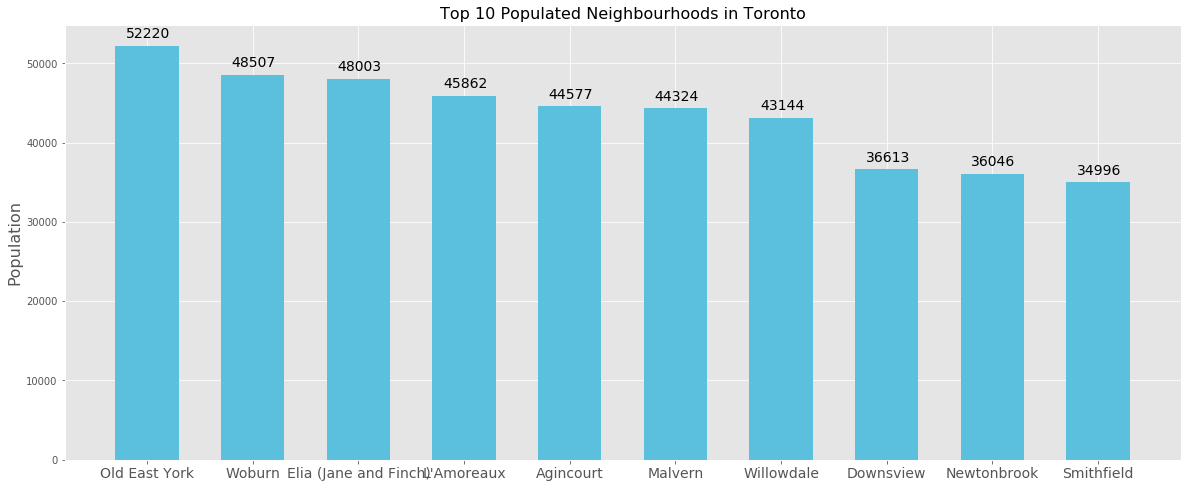

In [15]:
df_pop = df_by_population[['Neighbourhood', 'Population']].head(10).copy()
df_pop.set_index('Neighbourhood', inplace=True)

ind = np.arange(10)
populations = df_pop.Population.tolist()
bar_width = 0.6

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111)
plt.xticks(ind , (df_pop.index), rotation='horizontal', fontsize=14)
ax.bar(ind, populations, bar_width, color="#5bc0de")

ax.set_title('Top 10 Populated Neighbourhoods in Toronto', fontsize=16)
ax.set_ylabel("Population", fontsize=16)

for index, value in enumerate(populations):
    ax.text(index - bar_width / 3, value + 1000, "{}".format(value), fontsize=14)
     
ax

#### B. Visualization of neighbourhoods on Toronto map

In [17]:
df_neighbourhoods = df1[['Neighbourhood', 'Latitude', 'Longitude']]
df_neighbourhoods = df_neighbourhoods.dropna()
df_neighbourhoods.reset_index(inplace=True)
df_neighbourhoods.drop(['index'], axis=1, inplace=True)


toronto_location = geolocator.geocode('Toronto')
toronto_latitude, toronto_longitude = toronto_location.latitude, toronto_location.longitude
toronto_map = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=11)

for latitude, longitude, neighbourhood in zip(df_neighbourhoods['Latitude'], df_neighbourhoods['Longitude'], df_neighbourhoods['Neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  

toronto_map

### 5. Exploring the top neighbourhood

#### A. Forming the API request

In [18]:
df_by_population = df1.sort_values('Population Score', ascending=False)
top_neighbourhood = df_by_population.head(1)

top_neighborhood_latitude = top_neighbourhood.Latitude[112]
top_neighborhood_longitude = top_neighbourhood.Longitude[112]
top_neighborhood_name = top_neighbourhood.Neighbourhood[112]

print('Latitude and longitude of {} are {}, {}.\n'.format(top_neighborhood_name, 
                                                               top_neighborhood_latitude, 
                                                               top_neighborhood_longitude))

LIMIT = 100
radius = 500
search_query = 'Gym'

foursquare_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                                   CLIENT_SECRET,
                                                                                                                                   top_neighborhood_latitude, 
                                                                                                                                   top_neighborhood_longitude, 
                                                                                                                                   VERSION, 
                                                                                                                                   search_query, 
                                                                                                                                   radius, 
                                                                                                                                   LIMIT)

print(foursquare_url)

Latitude and longitude of Old East York are 43.6708625, -79.3727924125372.

https://api.foursquare.com/v2/venues/search?client_id=FWABH3UY2JW0GJM0XA4S1YCIBRWG4XY44GB4FG2VOVC1T1GY&client_secret=NGWXIULWCHACLDQNI5GFPG43JWZ54FA4TSSR2JJBJGNBANFH&ll=43.6708625,-79.3727924125372&v=20181020&query=Gym&radius=500&limit=100


#### B. Gyms located in the top neighbourhood

In [19]:
results = requests.get(foursquare_url).json()
results_json = results['response']['venues']

df_top_venues = json_normalize(results_json)

def get_categories(results):
    venue_categories = []
    
    for venue in range(len(results)):
        category = results[venue]['categories'][0]['name']
        venue_categories.append(category)
        
    return venue_categories 
    
df_top_venues['categories'] = get_categories(results_json)
df_top_venues['GymorNot'] = df_top_venues['categories'].apply(lambda s: s.find('Gym'))
df_top_venues = df_top_venues.drop(df_top_venues[df_top_venues.GymorNot == -1].index)
df_top_venues.drop(['GymorNot',
                    'location.cc', 
                    'location.country', 
                    'location.crossStreet', 
                    'location.formattedAddress', 
                    'location.labeledLatLngs', 
                    'location.postalCode', 
                    'location.state', 
                    'referralId', 
                    'hasPerk', 
                    'location.address', 
                    'location.city', 
                    'id'], axis=1, inplace=True)


df_top_venues = df_top_venues.reindex(['name', 'categories', 'location.distance', 'location.lat', 'location.lng' ], axis=1)
df_top_venues.rename(columns={'name':'Name', 'categories':'Category', 'location.distance':'Distance', 'location.lat':'Latitude', 'location.lng':'Longitude'}, inplace=True)
df_top_venues['Neighbourhood'] = top_neighborhood_name
df_top_venues.reset_index(inplace=True)
df_top_venues.drop(['index'], axis=1, inplace=True)

df_top_venues

,Name,Category,Distance,Latitude,Longitude,Neighbourhood
0,Rogers Gym,Gym,583,43.670390,-79.380010,Old East York
1,Gym @ 225 Wellesley,Gym,399,43.667314,-79.372083,Old East York
2,Verve Gym,Gym / Fitness Center,552,43.666702,-79.376539,Old East York
3,The 500 on Sherbourne's Fitness Gym,Gym / Fitness Center,422,43.667601,-79.375471,Old East York
4,18 Amelia Gym,Gym,485,43.667751,-79.368575,Old East York
5,X Gym,Gym,576,43.670150,-79.379880,Old East York


### 6. Exploring the whole Toronto

#### A. Forming the API requests for all neighbourhoods

In [21]:
def get_neighbourhoods(df):
    neighbourhoods = {}
    for i in df.index:
        neighbourhoods[df.iloc[i, 0]] = (df.iloc[i, 1], df.iloc[i, 2])
    
    return neighbourhoods


def search_neighbourhood(neighbourhood, latitude, longitude):    
    LIMIT = 100
    radius = 500
    search_query = 'Gym'  
      
    foursquare_url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID,
                                                                                                                                                  CLIENT_SECRET,
                                                                                                                                                  latitude,
                                                                                                                                                  longitude,
                                                                                                                                                  VERSION,
                                                                                                                                                  search_query,
                                                                                                                                                  radius,
                                                                                                                                                  LIMIT)
    return (neighbourhood, foursquare_url)

    
def form_urls():
    neighbourhoods_mapping = get_neighbourhoods(df_neighbourhoods)    
    search_urls = []
    
    for neighbourhood, coordinates in neighbourhoods_mapping.items():
        search_urls.append(search_neighbourhood(neighbourhood, coordinates[0], coordinates[1]))
        
    return search_urls

urls = form_urls()  # This list has all the API requests for every neighbourhood in Toronto.
print(len(urls), 'API requests formed.')

164 API requests formed.


#### B. Collecting gym data with the API requests

In [22]:
def search_toronto(urls):
    
    df_toronto_gyms = pd.DataFrame()
    
    for neighbourhood, api_request in urls:
        results = requests.get(api_request).json()  # Sending each API request in the urls and collecting the data.
        results_json = results['response']['venues']
        df_top_venues = json_normalize(results_json)
        df_top_venues['Neighbourhood'] = neighbourhood  # Adding the neighbourhood to the corresponding column.
        df_toronto_gyms = df_toronto_gyms.append(df_top_venues, ignore_index=True, sort=True)
        
    return df_toronto_gyms

df_toronto_gyms = search_toronto(urls)

# Getting the category type of each row.
for i in df_toronto_gyms.index:
    if df_toronto_gyms.iloc[i, 1]:
        df_toronto_gyms.iloc[i, 1] = df_toronto_gyms.iloc[i, 1][0]['name']  

print(df_toronto_gyms.shape[0], 'Gyms found in Toronto.')

337 Gyms found in Toronto.


In [23]:
df_toronto_gyms.head()

,Neighbourhood,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,Alderwood,Gym,False,4fb1faa6e4b04fafbc763bb4,88 Foch Ave.,CA,Etobicoke,Canada,"Brownsline,horner",518.0,"[88 Foch Ave. (Brownsline,horner), Etobicoke O...","[{'label': 'display', 'lat': 43.59848956825414...",43.598490,-79.546956,m8w 3x7,ON,maries gym,v-1540266976
1,Alderwood,Gym,False,4b9fbdb4f964a520583a37e3,77 Browns Line,CA,Toronto,Canada,NaN,290.0,"[77 Browns Line, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.59983195234328...",43.599832,-79.542924,NaN,ON,Toronto Gymnastics International,v-1540266976
2,Alexandra Park,Recreation Center,False,533a7f03498eb1ddea6546c7,NaN,CA,NaN,Canada,NaN,524.0,[Canada],"[{'label': 'display', 'lat': 43.64694393311080...",43.646944,-79.400464,NaN,NaN,525 Gym,v-1540266976
3,Alexandra Park,Gym,False,4e4734a07d8b91a0659aaef9,NaN,CA,Toronto,Canada,NaN,465.0,"[Toronto ON, Canada]","[{'label': 'display', 'lat': 43.647827, 'lng':...",43.647827,-79.400183,NaN,ON,The Morgen Condos Gym,v-1540266976
4,Amesbury,Gym / Fitness Center,False,4bc1dd11b492d13a3786a660,Keele St,CA,Toronto,Canada,NaN,603.0,"[Keele St, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.70389536626408...",43.703895,-79.476557,NaN,ON,Gyro's Gymnastics,v-1540266977


#### C. Cleaning the gym data

In [23]:
# Dropping rows where the category is not Gym.
for i in df_toronto_gyms.index:
    if df_toronto_gyms.iloc[i, 1] == []:
        df_toronto_gyms.iloc[i, 1] = ''
    if df_toronto_gyms.iloc[i, 1].find('Gym') == -1:
        df_toronto_gyms.iloc[i, 1] = np.nan
        
df_toronto_gyms.dropna(subset=['categories'], inplace=True)

In [24]:
# Dropping and renaming columns
df_gyms = df_toronto_gyms.drop(['location.cc', 
                    'location.country', 
                    'location.crossStreet', 
                    'location.labeledLatLngs',
                     'referralId',
                     'hasPerk',
                     'location.address',
                     'location.postalCode',
                     'location.state',
                     'location.city', 
                     'location.formattedAddress'], axis=1)

df_gyms = df_gyms.reindex(['name', 'Neighbourhood', 'categories', 'location.distance', 'location.lat', 'location.lng', 'id'], axis=1)
df_gyms.rename(columns={'name':'Name', 'categories':'Category', 'location.distance':'Distance', 'location.lat':'Latitude', 'location.lng':'Longitude', 'id':'VenueID'}, inplace=True)
df_gyms.reset_index(inplace=True)
df_gyms.drop(['index'], axis=1, inplace=True)

In [25]:
print('There are {} gyms in Toronto after cleaning the data.\n'.format(df_gyms.shape[0]))

df_gyms.drop_duplicates(subset=['VenueID'], keep=False, inplace=True)

print('There are {} gyms in Toronto after dropping the duplicates.\n'.format(df_gyms.shape[0]))

df_gyms.reset_index(inplace=True)
df_gyms.drop(['index'], axis=1, inplace=True)
df_gyms.head()

There are 255 gyms in Toronto after cleaning the data.

There are 124 gyms in Toronto after dropping the duplicates.



,Name,Neighbourhood,Category,Distance,Latitude,Longitude,VenueID
0,Gyro's Gymnastics,Amesbury,Gym / Fitness Center,603.0,43.703895,-79.476557,4bc1dd11b492d13a3786a660
1,Private Gym,Bay Street Corridor,Gym,332.0,43.667754,-79.389838,516acb78498e109d0a305de8
2,1121 Bay Street Gym,Bay Street Corridor,Gym / Fitness Center,317.0,43.667970,-79.388806,503fc226e4b000bf50e72b05
3,Omni Gym,Bendale,Gym / Fitness Center,489.0,43.749211,-79.254126,4d45e76a2e326ea873abf2a6
4,Dufferin Liberty Centre Gym,Brockton,Gym / Fitness Center,161.0,43.636685,-79.426204,4baa44fbf964a52080593ae3


In [26]:
# Grouping the gyms in neighbourhoods by their count and displaying the top neighbourhoods.
df_gym_counts = df_gyms.groupby('Neighbourhood').count().drop(['Name', 'Category', 'Distance', 'Latitude', 'Longitude'], axis=1).rename(columns={'VenueID':'GymCount'})
df_gym_counts = df_gym_counts.sort_values(by=['GymCount'], ascending=False)
df_gym_counts.head(10)

,GymCount
Neighbourhood,
Fashion District,24
Garden District,13
Financial District,12
Fort York/Liberty Village,9
North York City Centre,5
Davisville,5
Niagara,3
Scarborough City Centre,3
Downsview,3


In [27]:
# Adding the column of percentage in total.
gym_count = df_gym_counts['GymCount'].sum()
df_gym_counts['Weight'] = df_gym_counts['GymCount'] / gym_count * 100
df_gym_counts = df_gym_counts.reset_index()
df_gym_counts.head(10)

,Neighbourhood,GymCount,Weight
0,Fashion District,24,19.354839
1,Garden District,13,10.483871
2,Financial District,12,9.677419
3,Fort York/Liberty Village,9,7.258065
4,North York City Centre,5,4.032258
5,Davisville,5,4.032258
6,Niagara,3,2.419355
7,Scarborough City Centre,3,2.419355
8,Downsview,3,2.419355
9,Islington – Six Points,3,2.419355


#### D. Merging neighbourhood and gym data

In [32]:
df_ng = df1.drop(columns=['2nd Language', '2nd Language %', 'Transit Commuting', 'Density'], axis=1)
df_ng['GymCount'] = 0
df_ng['GymScore'] = 0

# Adding Gym Count and Weight to the previous data frame.
for i in df_ng.index:
    for j in df_gym_counts.index:        
        if df_ng.loc[i, 'Neighbourhood'] == df_gym_counts.loc[j, 'Neighbourhood']:
            df_ng.loc[i, 'GymCount'] = df_gym_counts.loc[j, 'GymCount']
            df_ng.loc[i, 'GymScore'] = df_gym_counts.loc[j, 'Weight']
            
df_ng.columns = df_ng.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_ng.head(10)

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore
0,Agincourt,44577,12.45,4.6,"25,750",Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000
1,Alderwood,11656,4.94,-4.0,"35,239",Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000
2,Alexandra Park,4355,0.32,0.0,"19,687",,,43.6508,-79.4043,0.180273,0,0.000000
3,Allenby,2513,0.58,-1.0,"245,592",,,43.7114,-79.5534,0.104025,0,0.000000
4,Amesbury,17318,3.51,1.1,"27,546",,,43.7062,-79.4834,0.716872,1,0.806452
5,Armour Heights,4384,2.29,2.0,"116,651",,,43.7439,-79.4309,0.181474,0,0.000000
6,Banbury,6641,2.72,5.0,"92,319",,,43.7428,-79.37,0.274902,0,0.000000
7,Bathurst Manor,14945,4.69,12.3,"34,169",North York,M3H,43.7543,-79.4423,0.618642,0,0.000000
8,Bay Street Corridor,4787,0.11,3.0,"40,598",,,43.6653,-79.3875,0.198156,2,1.612903
9,Bayview Village,12280,4.14,41.6,"46,752",North York,M2K,43.7869,-79.386,0.508326,0,0.000000


In [33]:
# Changing the types for plotting
df_ng['average_income'] = df_ng['average_income'].str.replace(',','')
df_ng.loc[63, 'average_income'] = 45792
df_ng['average_income'] = df_ng['average_income'].apply(pd.to_numeric)
df_ng['land_area'] = df_ng['land_area'].apply(pd.to_numeric)
df_ng['population_change'] = df_ng['population_change'].apply(pd.to_numeric)

In [34]:
df_ng.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore
0,Agincourt,44577,12.45,4.6,25750,Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000
1,Alderwood,11656,4.94,-4.0,35239,Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000
2,Alexandra Park,4355,0.32,0.0,19687,,,43.6508,-79.4043,0.180273,0,0.000000
3,Allenby,2513,0.58,-1.0,245592,,,43.7114,-79.5534,0.104025,0,0.000000
4,Amesbury,17318,3.51,1.1,27546,,,43.7062,-79.4834,0.716872,1,0.806452


### 7. Visualizing the found data

#### A. Separating the neighbourhoods with gym for training

In [35]:
df_with_gym = df_ng[df_ng['gymcount'] > 0].sort_values(by='gymcount', ascending=False).reset_index().drop(columns=['index'])
df_with_gym.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore
0,Fashion District,4642,0.98,123.0,63282,,,43.6455,-79.395,0.192154,24,19.354839
1,Garden District,8240,0.52,17.0,37614,Downtown Toronto,M5B,43.6572,-79.3789,0.341092,13,10.483871
2,Financial District,548,0.47,6.0,63952,,,43.6487,-79.3815,0.022684,12,9.677419
3,Fort York/Liberty Village,3821,2.13,126.0,46086,,,43.6396,-79.4106,0.158169,9,7.258065
4,North York City Centre,10427,0.28,33.0,34330,,,43.7685,-79.414,0.431622,5,4.032258


#### B. Visualizing population, land_area, population_change and average_income as independent variables, and  gym count as dependent variable

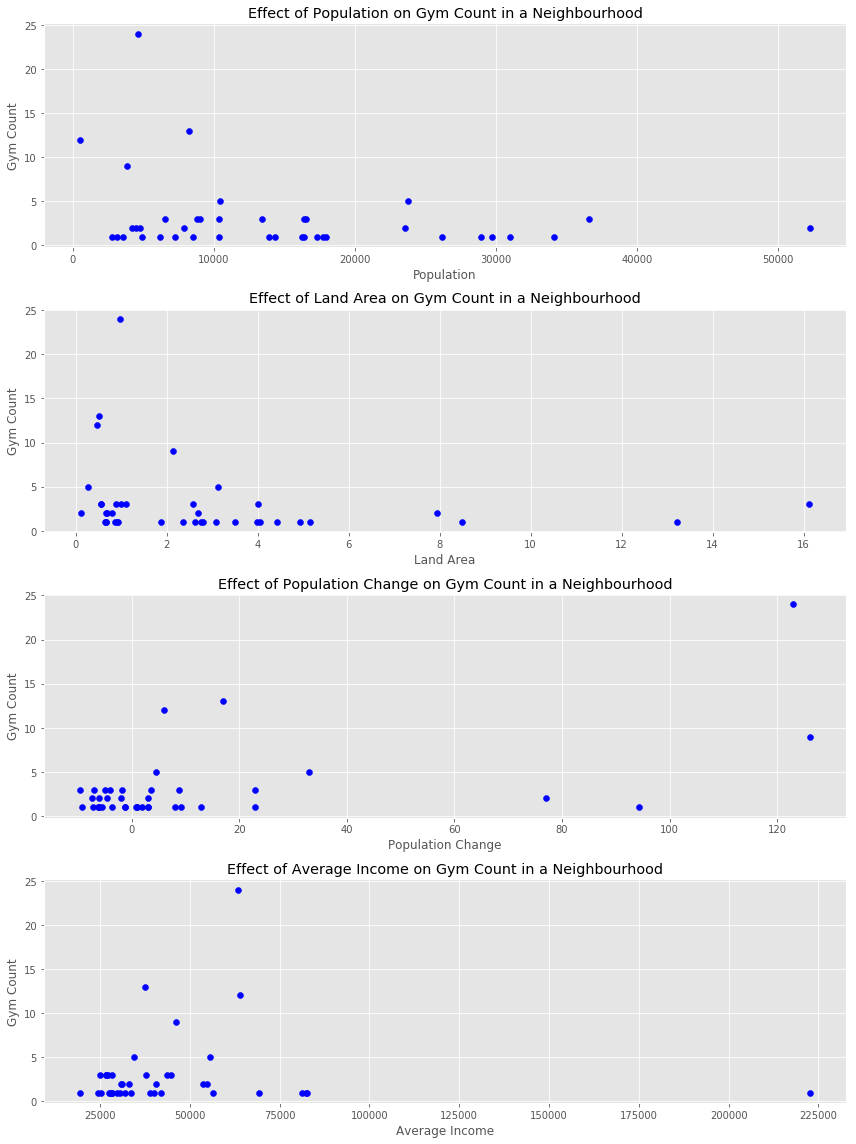

In [36]:
plt.figure(1, figsize=(12, 16))
plt.subplot(411)
x = np.asanyarray(df_with_gym[['population']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Population on Gym Count in a Neighbourhood')
plt.xlabel("Population")
plt.ylabel("Gym Count")

plt.subplot(412)
x = np.asanyarray(df_with_gym[['land_area']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Land Area on Gym Count in a Neighbourhood')
plt.xlabel("Land Area")
plt.ylabel("Gym Count")

plt.subplot(413)
x = np.asanyarray(df_with_gym[['population_change']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Population Change on Gym Count in a Neighbourhood')
plt.xlabel("Population Change")
plt.ylabel("Gym Count")

plt.subplot(414)
x = np.asanyarray(df_with_gym[['average_income']])
y = np.asanyarray(df_with_gym[['gymcount']])
plt.scatter(x, y,  color='blue')
plt.title('Effect of Average Income on Gym Count in a Neighbourhood')
plt.xlabel("Average Income")
plt.ylabel("Gym Count")

plt.tight_layout()
plt.show()

In [37]:
# There is no significant correlation between those variables and gym count in a neighbourhood.
df_corr = df_with_gym[['population', 'land_area', 'population_change', 'average_income', 'gymcount']].corr()
df_corr

,population,land_area,population_change,average_income,gymcount
population,1.000000,0.743020,-0.269278,-0.341698,-0.258964
land_area,0.743020,1.000000,-0.179078,-0.167912,-0.190566
population_change,-0.269278,-0.179078,1.000000,0.146849,0.579025
average_income,-0.341698,-0.167912,0.146849,1.000000,0.046577
gymcount,-0.258964,-0.190566,0.579025,0.046577,1.000000


### 8. Logistic Regression

#### A. Converting gym count to one hot encoding for logistic regression

In [38]:
df_ng['gym'] = df_ng['gymcount'] > 0
df_ng.gym = df_ng.gym.astype(int)
df_ng.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore,gym
0,Agincourt,44577,12.45,4.6,25750,Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000,0
1,Alderwood,11656,4.94,-4.0,35239,Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000,0
2,Alexandra Park,4355,0.32,0.0,19687,,,43.6508,-79.4043,0.180273,0,0.000000,0
3,Allenby,2513,0.58,-1.0,245592,,,43.7114,-79.5534,0.104025,0,0.000000,0
4,Amesbury,17318,3.51,1.1,27546,,,43.7062,-79.4834,0.716872,1,0.806452,1


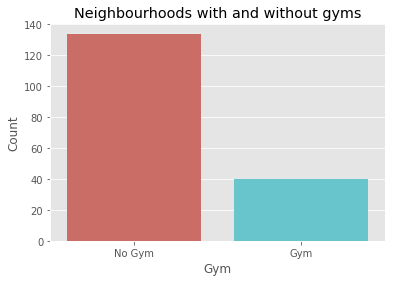

In [39]:
sns.countplot(x="gym", data=df_ng, palette="hls")
plt.title('Neighbourhoods with and without gyms')
plt.xlabel('Gym')
plt.ylabel('Count')
plt.xticks(np.arange(2), ('No Gym', 'Gym'))
plt.show()

#### B. Scaling the dependent variables

In [40]:
# Preparing the data for training.
X = np.asarray(df_ng[['population', 'land_area', 'population_change', 'average_income', 'population_score']])
y = np.asarray(df_ng['gym'])

X = preprocessing.StandardScaler().fit(X).transform(X)
X[:5]

array([[ 2.98296051e+00,  2.52141131e+00, -7.53041737e-05,
        -5.63412778e-01,  2.98296051e+00],
       [-2.16507469e-01,  4.06250039e-01, -3.75692523e-01,
        -3.36723575e-01, -2.16507469e-01],
       [-9.26064157e-01, -8.94954365e-01, -2.00986840e-01,
        -7.08255928e-01, -9.26064157e-01],
       [-1.10508120e+00, -8.21726412e-01, -2.44663260e-01,
         4.68854296e+00, -1.10508120e+00],
       [ 3.33760983e-01,  3.49629486e-03, -1.52942777e-01,
        -5.20506907e-01,  3.33760983e-01]])

#### C. Testing the model with split data

In [41]:
# Splitting the train and test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16) 
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (121, 5) (121,)
Test set: (53, 5) (53,)


In [42]:
# Fitting the model.
lr = LogisticRegression()
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))
yhat[:5]

Accuracy of logistic regression classifier on test set: 0.87


array([0, 0, 0, 0, 0])

In [43]:
# The probability of class 0 and 1.
yhat_prob = lr.predict_proba(X_test)
yhat_prob[:5]

array([[0.72355359, 0.27644641],
       [0.81398371, 0.18601629],
       [0.75617099, 0.24382901],
       [0.70337793, 0.29662207],
       [0.73478938, 0.26521062]])

In [44]:
# Out of 10 neighbourhoods with gym only 2 of them predicted correctly.
# Out of 43 neighbourhoods without a gym only one of them can't be predicted correctly.
cm = confusion_matrix(y_test, yhat, labels=[1,0])
cm

array([[ 2,  7],
       [ 0, 44]])

In [45]:
cr = classification_report(y_test, yhat)
print(cr)

             precision    recall  f1-score   support

          0       0.86      1.00      0.93        44
          1       1.00      0.22      0.36         9

avg / total       0.89      0.87      0.83        53



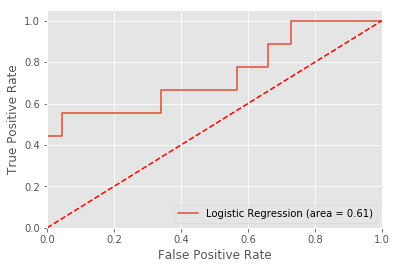

In [46]:
logit_roc_auc = roc_auc_score(y_test, yhat)
fpr, tpr, thresholds = roc_curve(y_test, yhat_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### D. Fitting the model with the whole data

In [49]:
df_ng_pred = df_ng.copy()
predicted_values = lr.predict(X)
prediction_probabilities = lr.predict_proba(X)
df_ng_pred['Predicted Values'] = predicted_values
df_ng_pred['Prediction Probability'] = [p.max() for p in prediction_probabilities]

In [52]:
# This is the result of prediction.
df_lr = df_ng_pred[df_ng_pred['Predicted Values'] == 1].drop(columns=['population', 'land_area', 'population_change', 'average_income', 'borough', 'postcode', 'population_score'])
df_lr

,neighbourhood,latitude,longitude,gymcount,gymscore,gym,Predicted Values,Prediction Probability
31,Corktown,43.6574,-79.3565,2,1.612903,1,1,0.557611
52,Fashion District,43.6455,-79.395,24,19.354839,1,1,0.707414
56,Fort York/Liberty Village,43.6396,-79.4106,9,7.258065,1,1,0.686134
64,Harbourfront / CityPlace,43.6401,-79.3801,1,0.806452,1,1,0.641900
167,Willowdale,43.7891,-79.4085,0,0.000000,0,1,0.549605


#### E. Result

According to the model, only the Willowdale neighborhood is predicted as having a gym even though it doesn't have one. It is the only false negative in the confusion matrix. The model thinks it is the only neighborhood that has same characteristics with other neighborhoods with gyms.

In [53]:
df_lr[df_lr['gym'] == 0]

,neighbourhood,latitude,longitude,gymcount,gymscore,gym,Predicted Values,Prediction Probability
167,Willowdale,43.7891,-79.4085,0,0.0,0,1,0.549605


### 9. K-Means Clustering

#### A. Preparing data for clustering

In [54]:
df_k = df_ng.drop(columns=['neighbourhood', 'borough', 'postcode'])
df_k['latitude'] = df_k['latitude'].apply(pd.to_numeric)
df_k['longitude'] = df_k['longitude'].apply(pd.to_numeric)
df_k.dropna(inplace=True)
df_k.reset_index(inplace=True)
df_k.drop(columns=['index'], inplace=True)

df_k.dtypes

population             int64
land_area            float64
population_change    float64
average_income         int64
latitude             float64
longitude            float64
population_score     float64
gymcount               int64
gymscore             float64
gym                    int64
dtype: object

In [55]:
df_k.head()

,population,land_area,population_change,average_income,latitude,longitude,population_score,gymcount,gymscore,gym
0,44577,12.45,4.6,25750,43.794200,-79.262029,1.845247,0,0.000000,0
1,11656,4.94,-4.0,35239,43.602414,-79.543484,0.482495,0,0.000000,0
2,4355,0.32,0.0,19687,43.650758,-79.404298,0.180273,0,0.000000,0
3,2513,0.58,-1.0,245592,43.711351,-79.553424,0.104025,0,0.000000,0
4,17318,3.51,1.1,27546,43.706162,-79.483368,0.716872,1,0.806452,1


#### B. Initializing k and fitting the model

In [56]:
k = 15
k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12, random_state=150).fit(df_k) # random_state is fixed in order to minimize the entropy.
k_means.labels_

array([ 5,  6, 10, 14,  0,  4,  2,  6,  7, 11,  6,  2,  9, 11, 13,  7, 10,
        3, 10, 11,  4, 10,  2,  6,  2, 10,  6,  6,  6,  6, 13, 10,  4, 10,
       11,  2,  7, 11,  9,  0, 10,  9, 10,  0,  0,  0,  0,  5,  6,  9, 13,
       13,  0,  2,  7,  6,  0,  6, 10,  6,  7,  8, 10, 13, 11,  6,  0,  1,
        6,  7, 10,  2, 10, 10, 10, 11, 10,  0,  6,  5,  7, 10,  6,  1,  2,
        2,  9,  6, 10,  6,  4,  5,  0, 11,  6,  9, 11, 12, 10,  0,  6,  9,
        7,  6, 10,  0,  5,  4,  9, 10,  9,  6,  0,  7, 11,  2, 10,  9,  9,
       11,  1,  0,  6,  7,  9,  0, 10,  7,  0,  9,  4, 10,  9,  2, 11,  8,
        9,  8,  8,  7, 10,  6,  4,  7,  0,  0,  7,  6,  0, 10,  7,  9,  7,
        0,  6,  0,  0,  5,  6,  5, 13,  2,  9,  4], dtype=int32)

In [57]:
# Adding the cluster labels to the corresponding rows.
df_l = df_ng.copy()
df_l = df_l.dropna()
df_l['cluster'] = k_means.labels_
df_l.head()

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore,gym,cluster
0,Agincourt,44577,12.45,4.6,25750,Scarborough,M1S,43.7942,-79.262,1.845247,0,0.000000,0,5
1,Alderwood,11656,4.94,-4.0,35239,Etobicoke,M8W,43.6024,-79.5435,0.482495,0,0.000000,0,6
2,Alexandra Park,4355,0.32,0.0,19687,,,43.6508,-79.4043,0.180273,0,0.000000,0,10
3,Allenby,2513,0.58,-1.0,245592,,,43.7114,-79.5534,0.104025,0,0.000000,0,14
4,Amesbury,17318,3.51,1.1,27546,,,43.7062,-79.4834,0.716872,1,0.806452,1,0


#### C. Cluster distribution

In [58]:
# Grouping neighbourhoods by their clusters.
df_counts = df_l.groupby('cluster').count()
df_counts = df_counts.drop(columns=[col for col in df_counts.columns if col != 'neighbourhood'], axis=1)
df_counts.sort_values(by='neighbourhood', ascending=False)

,neighbourhood
cluster,
6,27
10,26
0,23
9,17
7,16
2,12
11,12
4,8
5,7


#### D. Cluster ranking

In [59]:
df_lg = df_l[df_l['gym'] > 0]
df_lg = df_lg.groupby('cluster').sum()
df_lg['score'] = df_lg['gymscore'] / df_counts['neighbourhood']  # Ranking clusters by gym per neighbourhood
df_lg.sort_values(by='score', ascending=False)

,population,land_area,population_change,average_income,population_score,gymcount,gymscore,gym,score
cluster,,,,,,,,,
13,16646,3.71,198.0,291923,0.689055,41,33.064516,5,5.510753
7,28601,6.07,136.0,212237,1.183927,16,12.903226,5,0.806452
6,39981,2.16,52.7,140828,1.654998,23,18.548387,4,0.686977
11,40235,7.16,8.2,99305,1.665512,8,6.451613,2,0.537634
9,210133,54.09,-11.0,210776,8.698372,10,8.064516,7,0.474383
10,47042,4.48,-34.5,128456,1.947285,11,8.870968,5,0.341191
0,102050,20.54,21.6,172989,4.224319,8,6.451613,6,0.280505
1,3123,2.76,2.0,222560,0.129275,1,0.806452,1,0.268817
5,52220,7.94,-4.6,33172,2.161626,2,1.612903,1,0.230415


#### E. Cluster with the highest score

In [61]:
df_best_cluster = df_l[df_l['cluster'] == 13].drop(columns=['borough', 'postcode'])
df_best_cluster

,neighbourhood,population,land_area,population_change,average_income,latitude,longitude,population_score,gymcount,gymscore,gym,cluster
14,Bloor West Village,5175,0.74,-2.0,55578,43.6493,-79.4844,0.214217,0,0.000000,0,13
31,Corktown,4484,0.67,77.0,54681,43.6574,-79.3565,0.185613,2,1.612903,1,13
52,Fashion District,4642,0.98,123.0,63282,43.6455,-79.395,0.192154,24,19.354839,1,13
53,Financial District,548,0.47,6.0,63952,43.6487,-79.3815,0.022684,12,9.677419,1,13
66,Henry Farm,2790,0.91,-6.0,56395,43.7785,-79.3466,0.115491,1,0.806452,1,13
170,Wychwood,4182,0.68,-2.0,53613,43.6821,-79.4239,0.173112,2,1.612903,1,13


In [62]:
best_cluster = folium.Map(location=[latitude, longitude], zoom_start=11)

for latitude, longitude, neighbourhood in zip(df_best_cluster['latitude'], df_best_cluster['longitude'], df_best_cluster['neighbourhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(best_cluster)  

best_cluster

#### F. Result

According to the model, Bloor West Village should be in the cluster 13. Cluster 13 is the cluster with the neighborhoods that has highest number of gyms. All of the neighborhoods in this cluster has multiple gyms except Bloor West Village, but still it has the same characteristics as the other neighborhoods. Since they share the same characteristics, I think that, the demand for a gym in Bloor West Village will be high just like the other neighborhoods in the cluster.

In [63]:
df_best_cluster[df_best_cluster['gym'] == 0]

,neighbourhood,population,land_area,population_change,average_income,latitude,longitude,population_score,gymcount,gymscore,gym,cluster
14,Bloor West Village,5175,0.74,-2.0,55578,43.6493,-79.4844,0.214217,0,0.0,0,13


### 10. Final Result

In [64]:
df_ng[(df_ng.neighbourhood == 'Willowdale') | (df_ng.neighbourhood == 'Bloor West Village')]

,neighbourhood,population,land_area,population_change,average_income,borough,postcode,latitude,longitude,population_score,gymcount,gymscore,gym
14,Bloor West Village,5175,0.74,-2.0,55578,,,43.6493,-79.4844,0.214217,0,0.0,0
167,Willowdale,43144,7.68,62.3,39895,North York,M2M,43.7891,-79.4085,1.785929,0,0.0,0


* **Willowdale** was the only predicted false negative in the confusion matrix by the logistic regression model. The model predicted neighborhoods without gym with a %96 precision and only failed to predict this one correctly. That means it has same characteristics with other neighborhoods that has gym.

* **Bloor West Village** was the only neighborhood without a gym in the best cluster. The best cluster had neighborhoods with the highest number of gyms. This neighborhood share same characteristics with other neighborhoods in the cluster.

To conclude, those two neighborhoods share same characteristics with other neighborhoods which has higher demand of gyms. That's why it is less risky to start a gym in those neighborhoods rather than in other ones.